# Exercise 1.4.3 - Image Augmentations
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)

From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives

* Understand why data augmentation is useful and how it can help with object detection for self-driving cars;
* Experiment with the [Albumentations](https://albumentations.ai/docs/) library to perform various data augmentations;
* Test the augmentation pipeline on a few frames from the [Waymo Open Dataset]() and the [GTSRB]().

## 1. Introduction

In [1]:
### Importing the required modules

In [9]:
import albumentations as A
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

In [4]:
tf.__version__

'2.8.2'

In [5]:
tf.test.gpu_device_name()

''

In [6]:
### Setting the environment variables

In [7]:
ENV_COLAB = True                # True if running in Google Colab instance

In [8]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [10]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')
# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [ ]:
### Unzipping the GTSRB dataset
#!unzip -q /content/GTSRB.zip -d /content/data/

In [11]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_OUT, exist_ok=True)

### 1.1. Image Augmentations

* Why we use augmentation;
* A few popular augmentation methods;
* How to address the self-driving car domain shift.

#### Background

[Data augmentation](https://en.wikipedia.org/wiki/Data_augmentation) is a fundamental technique to increase generalisability of object detection models and decrease operational costs associated with data gathering. Comprising of two keywords _data_ and _augmentation_, this technique relies on _augmentation_ strategies to modify existing _data_. Data here implies a set of images and often corresponding bounding box coordinates. Augmentation in this case refers to geometric or pixel-wise transformations. Some common examples of augmentations are _flipping_, _rotating_, _blurring_ and _brightness adjustments_. Most of these transformations are applied at random to a given dataset in order to prevent [overfitting](https://en.wikipedia.org/wiki/Overfitting) during the training process. By modifying the training dataset at random, we introduce complexities and altercations to the data. Augmentation exposes the model to different versions of the original training data and thereby acts as a [regularisation](https://en.wikipedia.org/wiki/Regularization_\(mathematics\)) technique to improve the generalisability of a learned model.

#### Considerations for self-driving cars

Generalisability is especially important in the self-driving car domain, as object detection models need to perform especially well over many different factors across driving scenes. Some real-world variables that affect the generalisability of perception models in driving domains are lighting conditions (day/night), weather conditions (sunny/foggy/rainy), scale (adjusting perceived distance), camera intrinsics (lens properties) and extrinsics (position and orientation in ego vehicle frame), just to name a few. With data augmentation we are able to mimic time-of-day shifts, occlusions (obstructions in field-of-view), and certain camera properties that we otherwise might not have enough image data to account for. By using augmentation strategies we are also able to introduce _additional_ data into our training pipeline. This can not only help with model generalisability but also reduce the cost of data collection and labelling efforts. Data augmentation might also help us produce synthetic datasets for conditions or factors that are otherwise not possible to collect in bulk (accidents, one-off traffic conditions, irregular lane markings/street signs and other temporal conditions e.g., road work, natural disasters, etc.). As Waymo says in their [using automated data augmentation](https://blog.waymo.com/2020/04/using-automated-data-augmentation-to.html) blog post, "you have to be in the right place at the right time [to] capture a seal crossing the street or a man breakdancing on the sidewalk." With that said, data augmentation can help turn these rare occurrences into slightly less-rare occurrences by generating more training data needed to properly learn and react to these one-off scenarios.


Taking into account the purpose and specific use-cases applied to the driving domain is _extremely important_ when selecting data augmentation strategies. For example, introducing _flipping_ augmentation into a dataset could actually hurt generalisability of certain object detection models. Detectors trained on front-facing dashcam images for use on U.S. roads will (almost) never encounter [left-hand traffic](https://en.wikipedia.org/wiki/Left-_and_right-hand_traffic). By flipping images in our training set to mimic right-hand traffic, we might be forcing the model to overgeneralise to a driving scenario it will never see. Likewise, indiscriminately flipping images of certain road signs may result in a model's inability to discern the correct directional cues (e.g., _left_ from _right_ arrows) in the real-world environment. In addition to flipping, _random cropping_ might not be a particularly useful augmentation strategy for AD/ADAS perception models trained to operate on consistent hardware placed on consistent locations around a given vehicle. Shifting and scaling operations in this scenario might again force unwanted generalisations of the model to unlikely scenarios. In other words, a vehicle/hardware-coupled model will likely not be applied to different vehicles with different camera/sensor placements. Random scaling and shifting in this case might hurt the performance of a network that constantly receives image data from similarly-placed cameras around a given vehicle. In short, **data augmentation strategies should not be blindly selected**.

Lastly, it is important to note that while certain augmentations can mimic static parameters (time-of-day, weather patterns), the behaviour of other drivers in the original data will _not_ be augmented. Take a sunny driving scene, for example. By decreasing the brightness and adding blur, one can potentially mimic foggy driving conditions by modifying the original images. Yet, factors like the _braking distance_ to a lead vehicle will not have changed, as one would expect in this real-world condition.

#### Useful agumentations for self-driving cars

##### Cutout

[Cutout](https://albumentations.ai/docs/api_reference/augmentations/dropout/cutout/) is an augmentation technique that performs a coarse dropout of square regions in an image. In the Albumentation library, the `dropout.cutout.Cutout` augmentation class takes in several arguments that specify
* `num_holes`: the number of regions to select from an image at random;
* `max_h_size`, `max_w_size`: the maximum height/width of the cutout region (area to "delete");
* `fill_value`: the pixel value (or list of values) to replace the cutout region with.

Cutout augmentations do not drastically alter the camera intrinsic/extrinsic parameters (unlike flip, shift or scale). Instead, cutouts allow us to simulate occluded regions in a camera's field-of-view. In the real world, partially-occluded objects appear often (think: tree branch covering stop sign). Adding invariance to this type of phenomenon through simulated data via augmentation is generally a good idea.

##### Hue jitter

Hue jitter is from a class of augmentations that randomly adjust the colour properties of an image (the hue, brightness, contrast or saturation). The [`transforms.ColorJitter`](https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.ColorJitter) allows one to specify a scaling factor for any of these colour properties. For hue jitter, we specify a value (or range of `[min, max]` values) between `-0.5` and `0.5` to modify the hue by.

Using hue jitter can be especially important for object detection in the driving domain, as you would want a model to consistently detect a class of objects (e.g., vehicle) regardless of its colour properties (e.g., 'red' vehicle should be no different than 'blue' vehicle).

##### Blurring

In [ ]:
### TODO

##### More sophisticated techniques

Techniques such as _selective blending_ images or modifying directional lighting exist. Their "features" (parameters) need to be fine-tuned, often by hand, through a time-consuming process. Handcrafting these features is mostly a trial and error process limited to the imagination, time, and experience of the researcher. Despite these limitations, data augmentation proves to be a crucial step in any ML workflow — often resulting in performance gains greater than with fine-tuning model architecture alone.

##### Automated data augmentation

Effective data augmentation strategies often require expertise and manual labour to design. In order to formulate augmentation strategies (policies) for a _target_ task (e.g., traffic light recognition), one may utilise _proxy_ tasks (e.g., pedestrian object detection) to inform them of more-optimal augmentation strategies (the _search space_, i.e., the list of augmentations and parameters). A strong assumption made with this approach is that the selected proxy task closely relates to the broader task at-hand (e.g., object detection in the driving domain). However, even with this assumption, the learned augmentation policies may be sub-optimal with respect to the model and the dataset size in-question. 


Rather than limiting augmentation to pixel-level or geometric transformations, researchers have turned to architectures fine-tuned for data generation to produce unique image subsets. The _Smart Augmentation_ [1] model, like others in this class, is a generative model using Bayesian optimisation to learn the best sample blending (combination of images) for a specific task. Generative Adversarial Networks ([GAN](https://en.wikipedia.org/wiki/Generative_adversarial_network)) used for data generation transform the feature space with e.g., noise, interpolations that go beyond traditional operations. GANs have also been used to make optimal selections regarding the sequence of data augmentation operations to perform [2][3].


Because of the complications associated with optimal policy formulation, researchers at Google Brain have proposed methods for _automating_ data augmentation selection. _RandAugment_ [4] dramatically reduces the search space ("possible augmentations to use") by selecting augmentation strategies _at random_ with equal probability. _AutoAugment_ [5] expands on this by utilising reinforcement learning methods to search the parameter space and predict augmentation policies. The prediction strategies (denoted $S$) are used to train a child network to produce a validation accuracy $R$, which is then used as a reward for a Proximal Policy Optimization algorithm (Schulman et al., 2017).

Waymo, a pioneer in self-driving, started utilising the _RandAugment_ approach in 2019 for image-based classification and detection tasks. In [this](https://blog.waymo.com/2020/04/using-automated-data-augmentation-to.html) blog post, Waymo engineers report _significant improvements_ to mean average precision ([mAP](https://www.v7labs.com/blog/mean-average-precision)) for their classifiers used to detect foreign objects such as construction equipment and animals. Waymo took image augmentation a step further and began applying similar strategies to their 3D LiDAR point cloud data.

<center><img src=https://1.bp.blogspot.com/-Wq9kxxCatYw/Xqhc_mmEMXI/AAAAAAAADww/tt_LkG8oJAE92DRBPM7dkPGBiuwpz8STwCNcBGAsYHQ/s640/auto_augment_4_1.gif alt="Animated GIF showing the various augmentation strategies Waymo has used on their LiDAR point cloud data. Here a pedestrian-like figurine is shown with distortions (random flip, scaling, translation) applied to the figurine."></center>
$$
\textrm{Fig. 1. Augmentation strategies for LiDAR point clouds (credit:} \href{https://blog.waymo.com/2020/04/using-automated-data-augmentation-to.html}{ \ Waymo} \textrm{).}
$$

Shown in Fig. 1 is a number of augmentations/distortions selected for this task. What is particularly novel about Waymo's approach is the introduction of the _Population Based Augmentation_ (PBA) and _Progressive Population Based Augmentation_ (PPBA) model approaches for generating nonstationary augmentation policy schedules [6][7]. In short, these models are trained with principles similar to Darwin's Natural Selection Theory to optimise augmentation strategies. They narrow down the search space at each population iteration and record the best parameters in past iterations as references for mutating parameters in future iterations. 

##### In summary

At this point, you may be asking yourself: _why are these approaches all that important?_ 

Well, companies like Waymo have shown promising results (up to 10x data efficiency improvements!) when utilising augmentation strategies on the [Waymo Open Dataset](https://waymo.com/open). Using that as motivation, automated augmentation strategies such as PPBA can be faster and more efficient techniques to improve model generalisability and handle class imbalances/overfitting more so than with hand-tuning augmentation parameters alone. These efforts can enable self-driving car companies to increase efficiency beyond what is possible with manual annotation schemes, allowing them to cut costs and increase throughput — ultimately pushing us all closer to the goal of fully-autonomous vehicles.

## 2. Programming Task

### 2.1. Image Augmentations

In [26]:
### From Udacity's `utils.py`

In [27]:
def plot_batch(batch):
    indices = np.random.choice(range(256), replace=False, size=10)
    f, ax = plt.subplots(2, 5, figsize=(15, 5))
    for i, idx in enumerate(indices):
        x = i // 5
        y = i % 5
        im = batch[idx, ...]
        im *= 255
        im = im.astype(np.uint8)
        ax[x, y].imshow(im)
    plt.tight_layout
    plt.show()

In [28]:
### From Udacity's `augmentations.py`

In [30]:
def aug_fn(image, transforms):
    """ augment an image """
    aug_data = transforms(image=image.squeeze())
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    return aug_img

In [31]:
def process_data(image, label):
    """ wrapper function to apply augmentation """
    aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
    return aug_img, label

#### Common augmentations

- [x] **Cutout**: adding random dropout to mimic occlusions;
- [x] **Hue jitter**: shifting hue by coefficient to mimic object colour changes e.g., vehicles;
- [x] **Blurring**: add blurring to mimic e.g., motion (high speed), foggy conditions;
- [x] **Padding**: add border of pixels to image perimeter to fit a certain size. 

##### Cutout

In [83]:
cutout = A.CoarseDropout(
            max_holes=12,
            min_holes=4,
            max_height=85,
            max_width=85,
            min_height=15,
            min_width=15,            
            fill_value=0.0,
            always_apply=False,
            p=0.2
)

##### Hue jitter

In [67]:
hue_jitter = A.ColorJitter(
            hue=[-0.2, 0.2],
            always_apply=False,
            p=0.2
)

##### Blurring

In [90]:
blur = A.Blur(
            blur_limit=15,
            always_apply=False,
            p=0.1
)

##### Padding

In [23]:
IMG_HEIGHT = 32
IMG_WIDTH = 32

In [91]:
pad = A.PadIfNeeded(
            min_height=IMG_HEIGHT,
            min_width=IMG_WIDTH,
            always_apply=True,
            p=1.0
)

Write down a list of relevant augmentations and store them in the `transforms` variable.

In [92]:
# SELECT RELEVANT AUGMENTATIONS
transforms = A.Compose([
            # Choose one with probability p from the list of augmentations
            A.OneOf([cutout, hue_jitter, blur], 
                    p=1.0),
            
])

In [93]:
test_file_path = 'segment-12208410199966712301_4480_000_4500_000_with_camera_labels_83.png'
test_image = Image.open(os.path.join(DIR_SRC, test_file_path))

In [94]:
transformed = transforms(image=np.asarray(test_image))

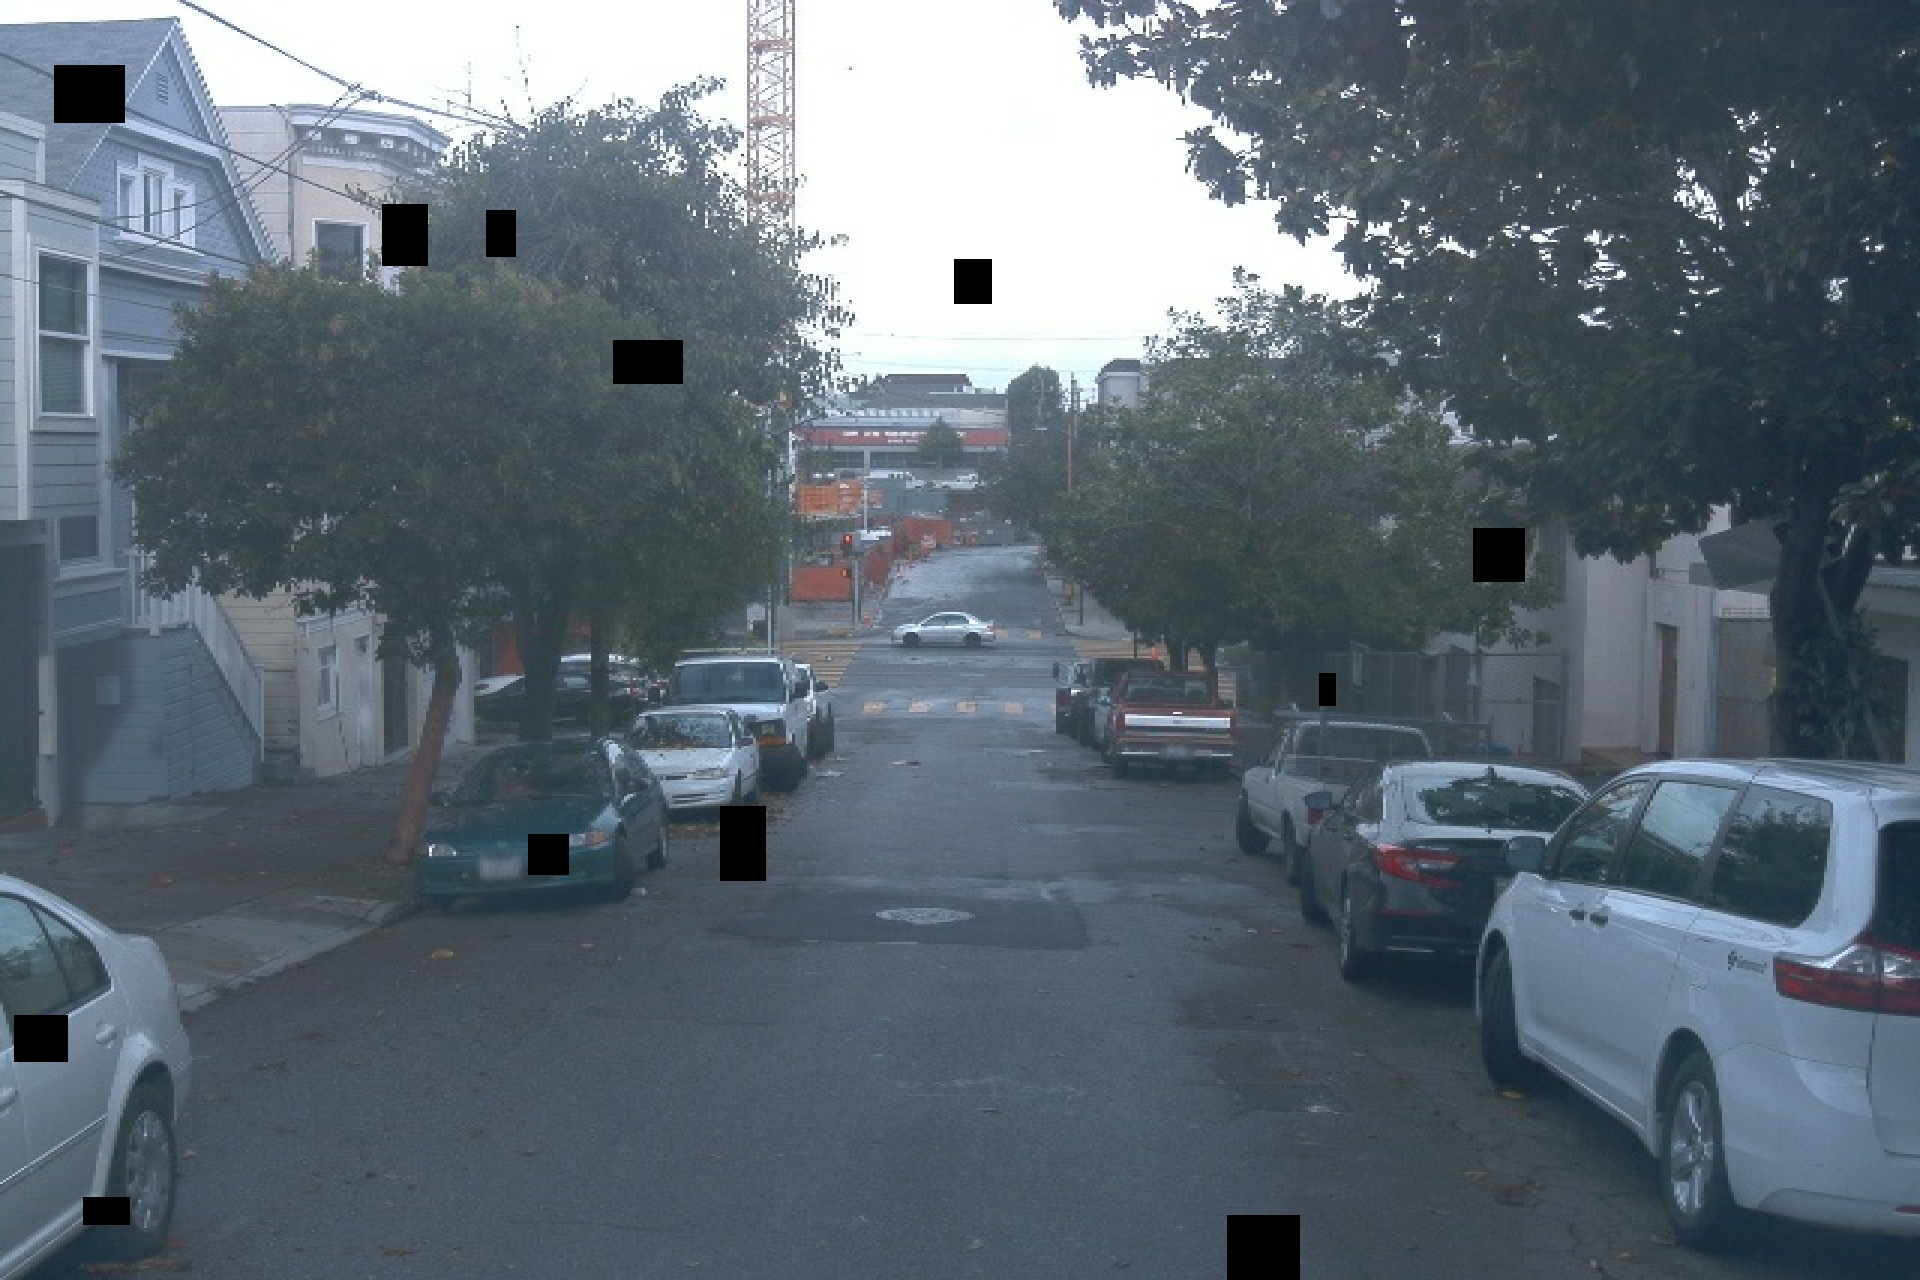

In [95]:
Image.fromarray(np.uint8(transformed['image']))

#### Augmentations for self-driving cars

- [ ] **Sun**/**Shade**: scale values by random brightness coefficient in HLS;
- [ ] **Shadows**: add random vertices with `fillPoly()`;
- [ ] **Snow**: scale values by large brightness coefficient in HLS;
- [ ] **Rain**: add random `line()`, blur, and shade;
- [ ] **Fog**: add blur and brighten random patches;
- [ ] **Torrential rain**: add blur, fog, and rain.

## Details

You should also implement a quick script to visualize the batches and check your augmentations.

You can run `python augmentations.py` to display augmented images (in the Desktop window).

In [ ]:
### From Udacity's `augmentations.py`

In [ ]:
parser = argparse.ArgumentParser(description='Augment dataset')
parser.add_argument('-d', '--imdir', required=True, type=str,
                    help='data directory')
args = parser.parse_args()    

dataset = image_dataset_from_directory(args.imdir, 
                                       image_size=(32, 32),
                                       validation_split=0.1,
                                       subset='training',
                                       seed=123,
                                       batch_size=1)

# APPLY AUGMENTATIONS AND DISPLAY BATCHES

## Tips

You should use the `Compose` API to use multiple augmentations. You can find an example of an augmentation pipeline using `Compose` [here](https://albumentations.ai/docs/examples/example/#define-an-augmentation-pipeline-using-compose-pass-the-image-to-it-and-receive-the-augmented-image).

This [Github repository](https://github.com/albumentations-team/albumentations_examples) contains different examples of augmentations.

## 3. Closing Remarks

##### Alternatives
* Use a custom augmentation library for self-driving cars (e.g., [Automold](https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library));

##### Extensions of task
* Implement a random choice algorithm for selecting augmentation parameters (e.g., RandAugment);


## Credits

This assignment was prepared by Thomas Hossler et al., Winter 2021 (link [here](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)).


References

[1] Lemely, J. et al., Smart Augmentation: Learning an Optimal Data Augmentation Strategy. IEEE Access, vol. 5:5858-5869. 2017. [doi:10.1109/ACCESS.2017.2696121](https://ieeexplore.ieee.org/document/7906545).

[2] Ratner, A. et al., Learning to Compose Domain-Specific Transformations for Data Augmentation. arXiv. 2017. [doi:10.48550/ARXIV.1709.01643](https://arxiv.org/abs/1709.01643).

[3] DeVries, T. et al., Dataset Augmentation in Feature Space. arXiv. 2017. [doi:10.48550/ARXIV.1702.05538](https://arxiv.org/abs/1702.05538).

[4] Cubuk, E. D. et al., RandAugment: Practical automated data augmentation with a reduced search space. Proceedings of the IEEE/CVF conference on computer vision and pattern recognition workshops. 2020. [doi:10.48550/ARXIV.1909.13719](https://arxiv.org/abs/1909.13719).

[5] Cubuk, E. D. et al., AutoAugment: Learning Augmentation Policies from Data. arXiv. 2018. [doi:10.48550/ARXIV.1805.09501](https://arxiv.org/abs/1805.09501).

[6] Ho, D. et al., Population Based Augmentation: Efficient Learning of Augmentation Policy Schedules. arXiv. [doi:10.48550/ARXIV.1905.05393](https://arxiv.org/abs/1905.05393).

[7] Cheng, S. et al., Improving 3D Object Detection through Progressive Population Based Augmentation. arXiv. [doi:10.48550/ARXIV.2004.00831](https://arxiv.org/abs/2004.00831).



Helpful resources:
* [When Conventional Wisdom Fails: Revisiting Data Augmentation for Self-Driving Cars by M. Cooper | Medium](https://towardsdatascience.com/when-conventional-wisdom-fails-revisiting-data-augmentation-for-self-driving-cars-4831998c5509)

* [Data Augmentation with GANs for Defect Detection by L. Melchoir | Medium](https://medium.com/dida-machine-learning/data-augmentation-with-gans-for-defect-detection-8318fab1a514)

* [Using automated data augmentation to advance our Waymo Driver | Waymo Waypoint Blog](https://blog.waymo.com/2020/04/using-automated-data-augmentation-to.html)

* [Image Augmentation: Make it ran, make it snow by U. Saxena | Medium](https://medium.com/free-code-camp/image-augmentation-make-it-rain-make-it-snow-how-to-modify-a-photo-with-machine-learning-163c0cb3843f)

* [Automold — specialized augmentation library for autonomous vehicles by U. Saxena | Medium](https://towardsdatascience.com/automold-specialized-augmentation-library-for-autonomous-vehicles-1d085ed1f578)